<a href="https://colab.research.google.com/github/jsonavalos/TSA-Analysis/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(readxl)
install.packages('fpp3')
install.packages("urca")
library(fpp3)
library(tidyverse)
library(fpp3)
library(slider)
library(urca)
library(scales)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘quadprog’, ‘progressr’, ‘ggdist’, ‘numDeriv’, ‘warp’, ‘BH’, ‘fabletools’, ‘distributional’, ‘slider’, ‘anytime’, ‘fable’, ‘feasts’, ‘tsibble’, ‘tsibbledata’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────── fpp3 1.0.2 ──

✔ tibble      3.3.0     ✔ tsibble     1.1.6
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.1     ✔ feasts      0.4.2
✔ lubridate   1.9.4     ✔ fable       0.4.1
✔ ggplot2     4.0.1     

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubrida

## Exploratory Data Analysis

In [ ]:
tsa_clean <- read_excel("/content/TSA.xlsx")

In [ ]:
head(tsa_clean)

Date,Numbers
<dttm>,<dbl>
2025-11-06,2703787
2025-11-05,2162183
2025-11-04,2015297
2025-11-03,2492532
2025-11-02,2279000
2025-11-01,2029517


In [ ]:
# Glimpse at dataset
glimpse(tsa_clean)

Rows: 2,502
Columns: 2
$ Date    <dttm> 2025-11-06, 2025-11-05, 2025-11-04, 2025-11-03, 2025-11-02, 2…
$ Numbers <dbl> 2703787, 2162183, 2015297, 2492532, 2279000, 2029517, 2678000,…


In [ ]:
# Number Column summary
summary(tsa_clean$Numbers)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 113147 1811221 2188235 2024965 2498146 3096797 

In [ ]:
# Missing data check
sum(is.na(tsa_clean$Numbers))

[1] 0

In [ ]:
# Range of the Dates
min(tsa_clean$Date); max(tsa_clean$Date)

[1] "2019-01-01 UTC"

[1] "2025-11-06 UTC"

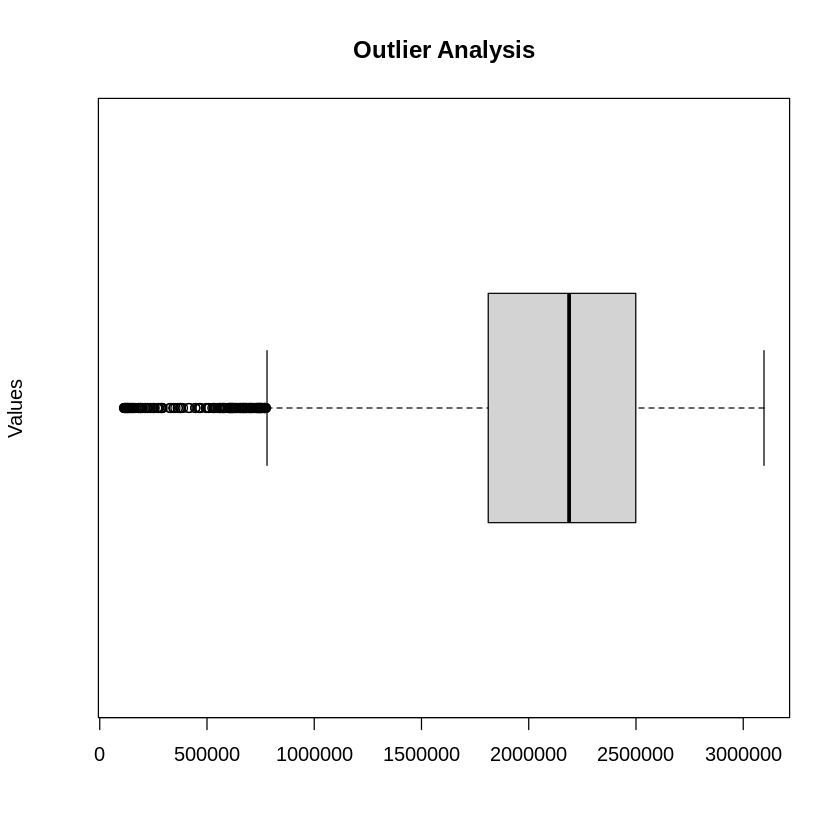

In [ ]:
# Outlier analysis
boxplot(tsa_clean$Numbers, main = "Outlier Analysis", ylab = "Values", horizontal = TRUE)

In [ ]:
# List of outliers -- 2020-2021
Q1 <- quantile(tsa_clean$Numbers, 0.25, na.rm = TRUE)
Q3 <- quantile(tsa_clean$Numbers, 0.75, na.rm = TRUE)
IQR_value <- IQR(tsa_clean$Numbers, na.rm = TRUE)

lower_bound <- Q1 - (1.5 * IQR_value)
upper_bound <- Q3 + (1.5 * IQR_value)

outliers <- tsa_clean |> filter(Numbers < lower_bound | Numbers > upper_bound)

head(outliers)

Date,Numbers
<dttm>,<dbl>
2021-01-06,705249
2021-01-09,750419
2021-01-11,750407
2021-01-12,557517
2021-01-13,605887
2021-01-16,729703


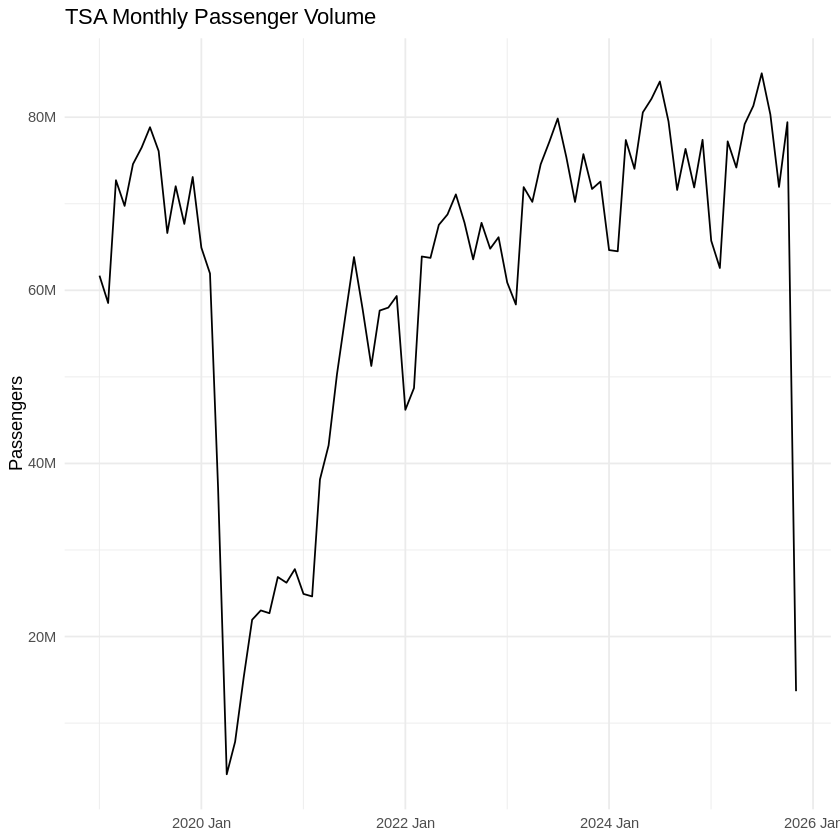

In [ ]:
tsa_monthly <- tsa_clean |>
  mutate(Month = yearmonth(Date)) |>
  group_by(Month) |>
  summarise(Total = sum(Numbers, na.rm = TRUE)) |>
  ungroup() |>
  as_tsibble(index = Month)

autoplot(tsa_monthly, Total) +
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale())) +
  labs(
    title = "TSA Monthly Passenger Volume",
    y = "Passengers",
    x = NULL
  ) +
  theme_minimal()

# Training/Test

Convert to TSIBBLE object, filter the months, and create a Totals Column.

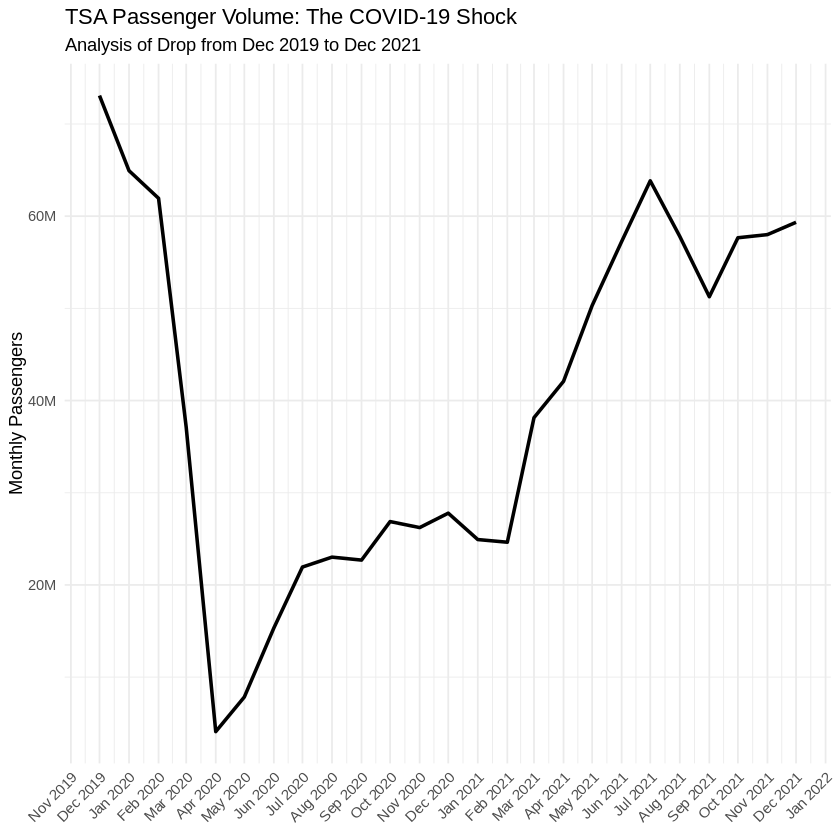

In [ ]:
covid_window <- tsa_monthly %>% # Changed from tsa_clean to tsa_monthly
  filter_index("2019 Dec" ~ "2021 Dec")

# Plot the Drop
covid_window %>%
  autoplot(Total, linewidth = 1) +

  # Formatting axes
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale())) +
  scale_x_yearmonth(date_breaks = "1 month", date_labels = "%b %Y") +

  labs(
    title = "TSA Passenger Volume: The COVID-19 Shock",
    subtitle = "Analysis of Drop from Dec 2019 to Dec 2021",
    y = "Monthly Passengers",
    x = NULL
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

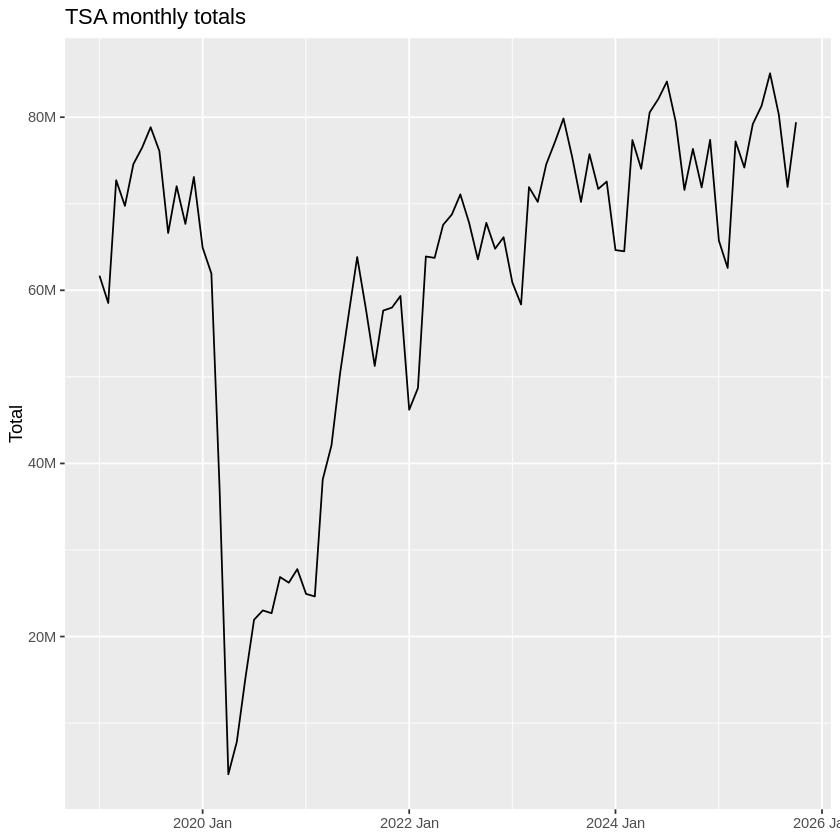

In [ ]:
# Expect columns: Date, Numbers (daily)
tsa_clean <- tsa_monthly %>%
  filter(Month < max(Month)) %>%
  filter(year(Month) >= 2019) %>%
  mutate(
    covid_shock = if_else(Month >= yearmonth("2020 Feb") & Month <= yearmonth("2021 Dec"), 1, 0) # dummy var for covid to inform models
  )

autoplot(tsa_clean, Total) + labs(title = "TSA monthly totals", x = NULL, y = "Total")+
scale_y_continuous(labels = label_number(scale_cut = cut_short_scale()))

In [ ]:
head(tsa_clean)

Month,Total,covid_shock
<mth>,<dbl>,<dbl>
2019 Jan,61694899,0
2019 Feb,58535547,0
2019 Mar,72714771,0
2019 Apr,69754997,0
2019 May,74582398,0
2019 Jun,76489355,0


### Monthly Timeseries Plot

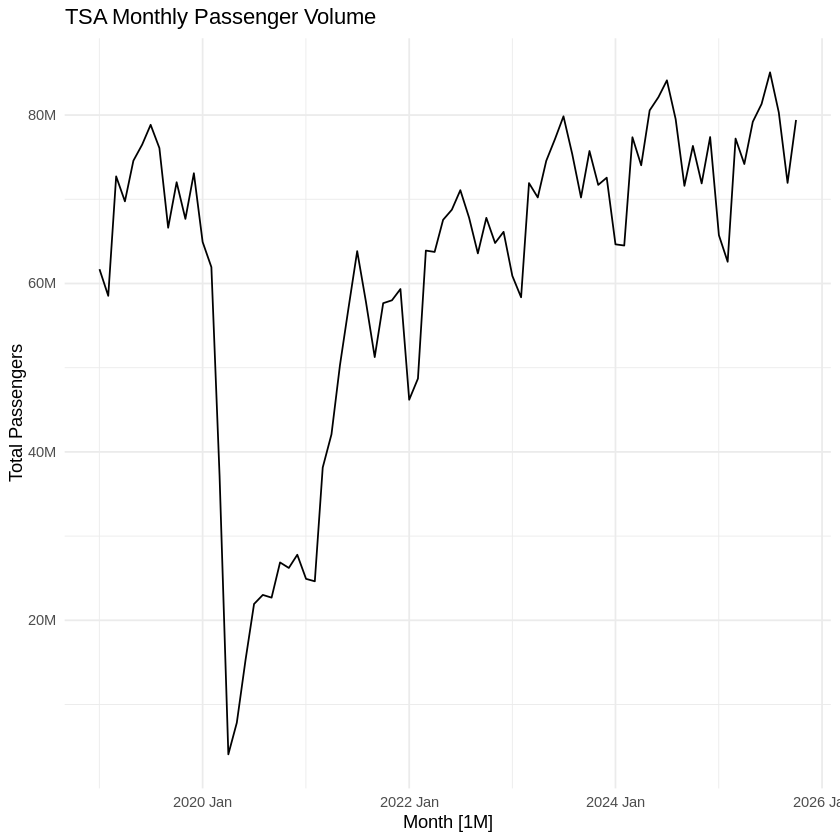

In [ ]:
tsa_clean %>%
  autoplot(Total) +
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale()))+
    labs(
    title = "TSA Monthly Passenger Volume",
    y = "Total Passengers"
  ) +
  theme_minimal()

### STL Decomposition

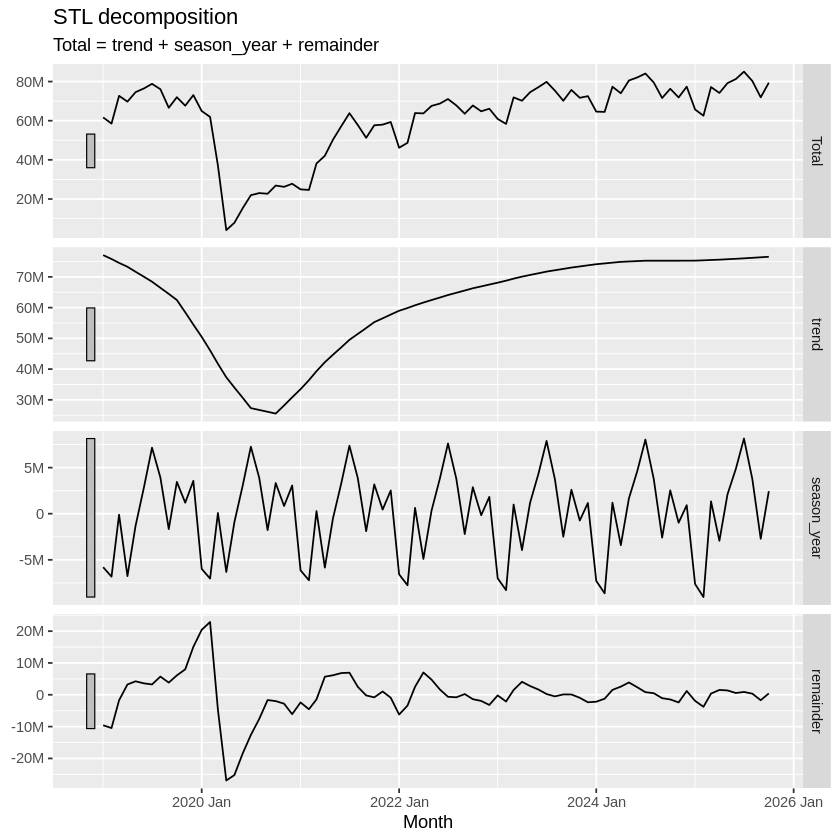

In [ ]:
tsa_clean %>%
  model(STL(Total)) %>%
  components() %>%
  autoplot()+
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale()))

### Training/Testing Phase

In [ ]:
h <- 12 # goo for evalaution seasonality

# train test, fit
n_total <- nrow(tsa_clean)
train <- tsa_clean %>% filter(year(Month) <= 2023)
test  <- tsa_clean %>% filter(year(Month) > 2023)

In [ ]:
max(test$Month) ; min(test$Month)

<yearmonth[1]>
[1] "2025 Oct"

<yearmonth[1]>
[1] "2024 Jan"

In [ ]:
max(train$Month) ; min(train$Month)

<yearmonth[1]>
[1] "2023 Dec"

<yearmonth[1]>
[1] "2019 Jan"

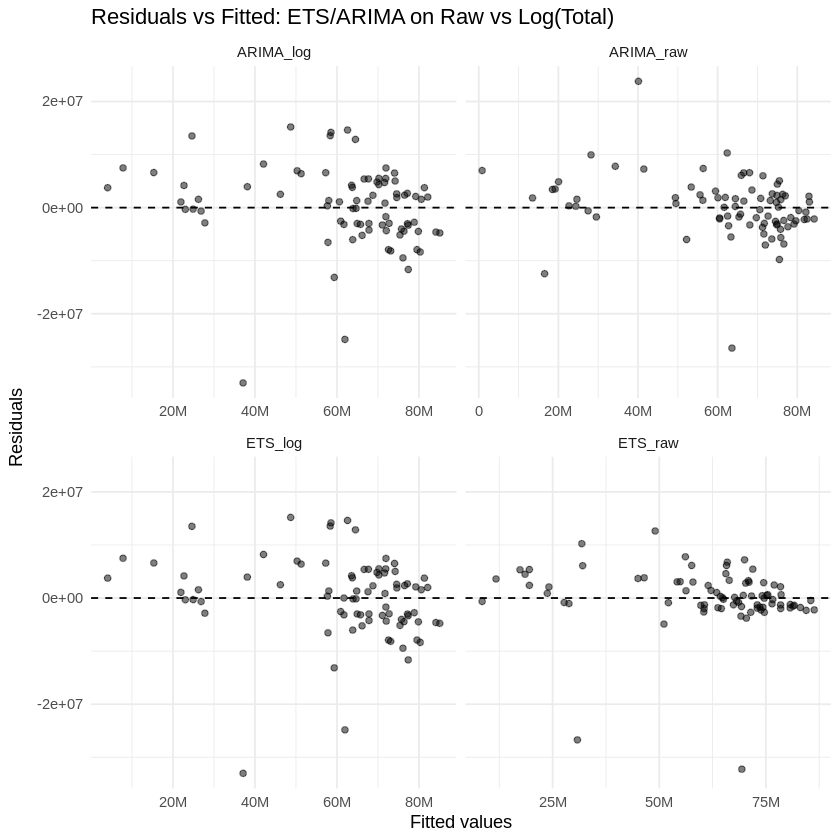

In [ ]:
# Simple diagnostic models (not your final comparison yet)
diag_fit <- tsa_clean %>%
  model(
    ETS_raw   = ETS(Total),
    ETS_log   = ETS(log(Total)),
    ARIMA_raw = ARIMA(Total),
    ARIMA_log = ARIMA(log(Total))
  )

# Residuals vs fitted for both
diag_resids <- diag_fit %>%
  augment()

diag_resids %>%
  ggplot(aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  facet_wrap(~ .model, scales = "free_x") +
  labs(
    title = "Residuals vs Fitted: ETS/ARIMA on Raw vs Log(Total)",
    x = "Fitted values",
    y = "Residuals"
  ) +
  scale_x_continuous(
    labels = scales::label_number(scale_cut = scales::cut_short_scale())
  ) +
  theme_minimal()

Residuals vs fitted plots for ETS and ARIMA on both the original and log-transformed scales show that the raw-scale models (ETS(Total) and ARIMA(Total)) have tighter, more homoscedastic residuals centered around zero. In contrast, the log-transformed models exhibit larger and more structured residuals. Together with the poorer RMSE/MAE for the log models, this indicates that a log transformation does not improve the fit and is not appropriate for this series. We therefore proceed using models on the original scale only.

### Fitting Stage

In [ ]:
fit <- train %>%
  model(
    ETS   = ETS(Total),
    ARIMA = ARIMA(Total),
    ARIMA_pd = ARIMA((Total) ~ covid_shock + season() + trend())
  )

fc <- new_data(train, n = nrow(test)) %>%
  mutate(covid_shock = 0)

fc <- fit %>%
  forecast(new_data = fc)

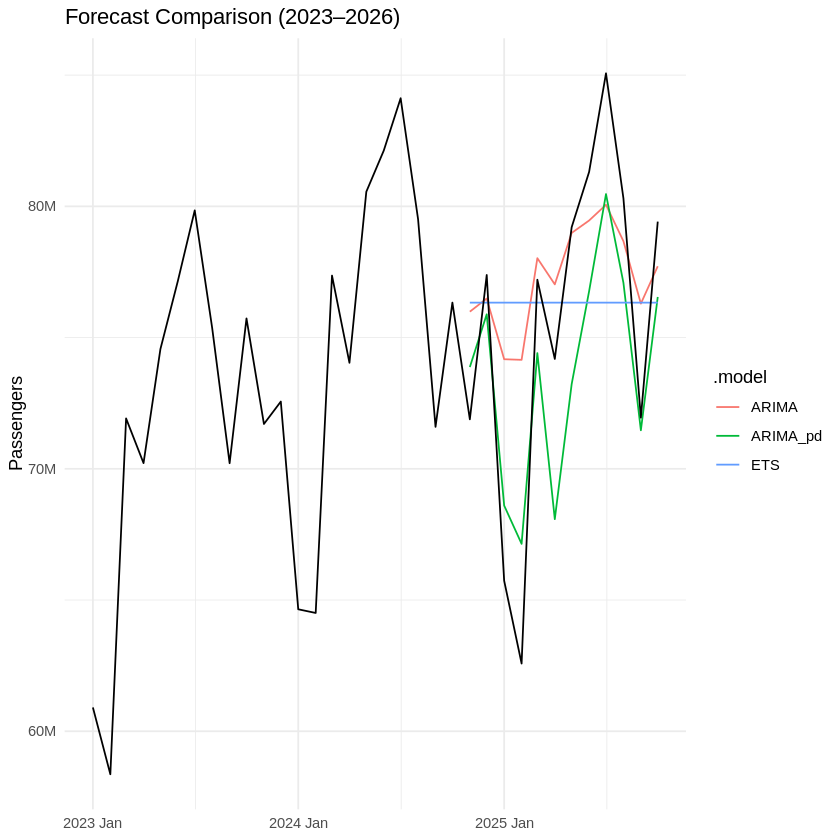

In [ ]:
fc %>%
  filter(year(Month) >= 2023) %>%
  autoplot(tsa_clean %>% filter(year(Month) >= 2023), level = NULL) +
    scale_y_continuous(labels = label_number(scale_cut = cut_short_scale())) +

  labs(
    title = "Forecast Comparison (2023–2026)",
    y = "Passengers",
    x = NULL
  ) +
  theme_minimal()

In [ ]:
acc_baseline_models <- accuracy(fc, test) %>%
  select(.model:MAPE)

acc_baseline_models %>%
  arrange(RMSE) %>%
  knitr::kable()



|.model   |.type |       ME|    RMSE|     MAE|       MPE|     MAPE|
|:--------|:-----|--------:|-------:|-------:|---------:|--------:|
|ARIMA_pd |Test  |  1889897| 3837743| 3459409|  2.184150| 4.586894|
|ARIMA    |Test  | -1734720| 4869214| 3618851| -2.850068| 5.144912|
|ETS      |Test  |  -811981| 6334927| 5075159| -1.825963| 7.051295|

# ARIMA Set-Up

In [ ]:
print('Stationary Test')
train |> fabletools::features(Total, c(unitroot_kpss, unitroot_ndiffs, unitroot_nsdiffs)) |> knitr::kable()

[1] "Stationary Test"




| kpss_stat| kpss_pvalue| ndiffs| nsdiffs|
|---------:|-----------:|------:|-------:|
| 0.5996051|   0.0226723|      1|       0|

Observation: Null hypothesis cannot be rejected 0.05. Therefore, series is stationary. 1 regular and 1 seasonal differentiation is required.

In [ ]:
print('Stationary test after applying a season and regular differentiation')
train |> fabletools::features(Total |>  difference(lag=1) , c(unitroot_kpss, unitroot_ndiffs, unitroot_nsdiffs)) |> knitr::kable()

#orders1 <- tsa_clean |>
#  mutate(Total_d = difference(difference(Total, lag = 12))) |>
#  features(Total_d, unitroot_kpss)
#print(orders1)

[1] "Stationary test after applying a season and regular differentiation"




| kpss_stat| kpss_pvalue| ndiffs| nsdiffs|
|---------:|-----------:|------:|-------:|
| 0.0898129|         0.1|      0|       0|

# Differenced series and ACF/PACF plots

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


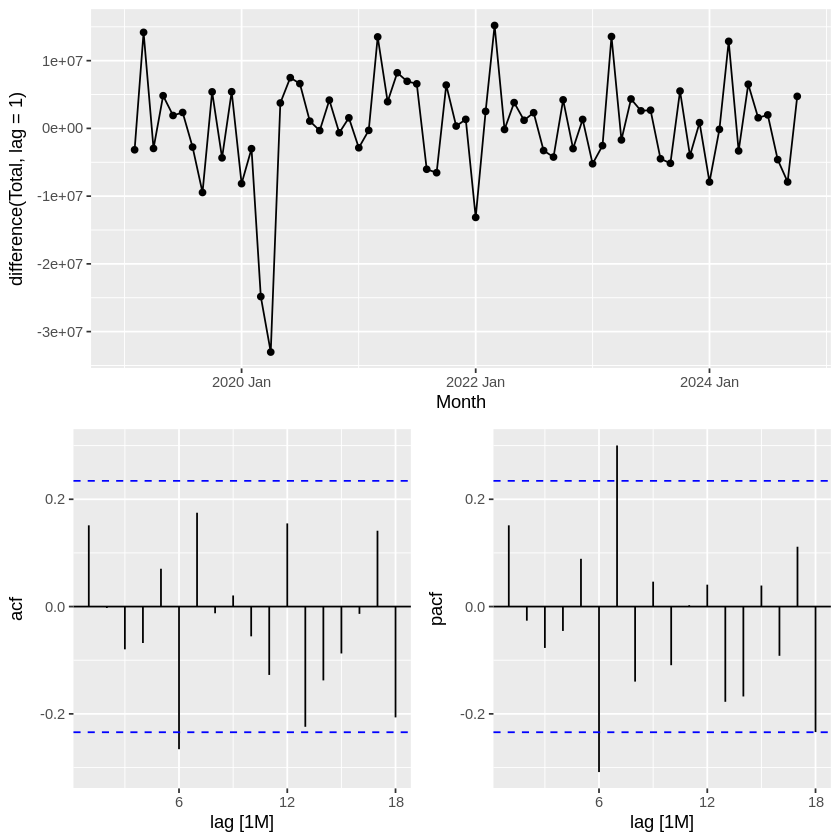

In [ ]:
# plot differenced series and ACF/PACF plots with non-seasonal and seasonal differencing

train |>
  feasts::gg_tsdisplay(
    Total |> difference(lag = 1),
    plot_type = "partial"
  )

In [ ]:
# model fit
fitted_manual_arima <- train |>
  model(
    ma1_manual = ARIMA(Total ~ pdq(0, 1, 1) + PDQ(0, 1, 1)),
    ar1_manual = ARIMA(Total ~ pdq(1, 1, 0) + PDQ(1, 1, 0))
  )

h_test <- nrow(test)

# Holds both forecast models
fc_manual_arima <- fitted_manual_arima |>
  forecast(h = h_test)

In [ ]:
# Manual ARIMA scores from Training Data
fitted_manual_arima |> glance() |> select(.model, AICc) |> arrange(AICc)

.model,AICc
<chr>,<dbl>
ma1_manual,1958.793
ar1_manual,1966.399


In [ ]:
all_models <- train |>
  model(
    ETS        = ETS(Total),
    auto_arima = ARIMA(Total),
    ma1_manual = ARIMA(Total ~ pdq(0, 1, 1) + PDQ(0, 1, 1)),
    ar1_manual = ARIMA(Total ~ pdq(1, 1, 0) + PDQ(1, 1, 0))
  )

all_models |> glance() |> select(.model, AICc) |> arrange(AICc)

.model,AICc
<chr>,<dbl>
ma1_manual,1958.793
ar1_manual,1966.399
auto_arima,2383.670
ETS,2523.592


All performance metrics combined

In [ ]:
forecast_all_models <- all_models |>
  forecast(h = nrow(test))

accuracy_combined <- forecast_all_models |>
  accuracy(tsa_clean) |>
  select(.model, RMSE, MAE, MAPE) |>
  arrange(RMSE)
accuracy_combined |> knitr::kable()



|.model     |    RMSE|     MAE|     MAPE|
|:----------|-------:|-------:|--------:|
|ar1_manual | 3084833| 2956425| 3.964491|
|ma1_manual | 3450831| 3064570| 4.100516|
|auto_arima | 4869214| 3618851| 5.144912|
|ETS        | 6334927| 5075159| 7.051295|

Based on test-set RMSE, the ARIMA(1,1,0)(1,1,0) model (ar1_manual) achieved the best out-of-sample performance (RMSE ≈ 5.7M), outperforming both ETS and the alternative ARIMA specifications. Although ma1_manual had slightly better AICc on the training data, ar1_manual provided superior accuracy on the holdout period, so we select ar1_manual as our final model. Log-transformed and pandemic-adjusted models all produced substantially larger RMSE values and were discarded.

# Accuracy Comparison with Cross-validation

In [ ]:
n_total <- nrow(tsa_clean)
train <- tsa_clean |> slice_head(n = n_total - h)
test  <- tsa_clean |> slice_tail(n = h)

cv_train <- tsa_clean |> slice_head(n = n_total - h) |> stretch_tsibble(.init=48, .step = 12)

In [ ]:
# new cv fits
cv_fits <- cv_train |>
  model(
    ETS       = ETS(Total),
    ARIMA     = ARIMA(Total),
    ma1_manual = ARIMA(Total ~ pdq(0,1,1) + PDQ(0,1,0)),
    ar1_manual = ARIMA(Total ~ pdq(1,1,0) + PDQ(0,0,1))
  )

In [ ]:
fc_cv_models <- cv_fits |> forecast(h = "12 months")


accuracy <- accuracy(fc_cv_models, tsa_clean) |> select(.model, .type, ME, RMSE, MAE, MAPE) |> arrange(RMSE)
accuracy |> knitr::kable()



|.model     |.type |       ME|     RMSE|      MAE|      MAPE|
|:----------|:-----|--------:|--------:|--------:|---------:|
|ma1_manual |Test  | -1145959|  2985843|  2177955|  3.054853|
|ar1_manual |Test  |  3354766|  6594746|  5904169|  8.039470|
|ETS        |Test  |  4095700|  7399181|  6646001|  9.014394|
|ARIMA      |Test  | 11219474| 13945564| 13005485| 17.332255|

Although ETS produced the best accuracy on the single 12-month hold-out set, its performance dropped considerably under rolling-origin cross-validation. This difference occurs because the simple train/test split evaluates the model on only one recent period (a relatively stable year), where ETS performs well. In contrast, time-series cross-validation tests the model across multiple historical forecasting scenarios, including volatile periods such as the COVID-19 shock and the recovery phase. In these more challenging conditions, ETS is less stable, while the manual ARIMA(0,1,1)(0,1,0) model remains consistently accurate. Therefore, cross-validation indicates that the ARIMA model is more robust overall and is the preferred final model.

**Workforce Prediction**

In [ ]:
# ---- Updated Workforce Assumptions (Based on TSA lane throughput) ----

current_agents <- 47500  # total TSOs (from DHS / TSA stats)

# Lane throughput per hour (typical)
pax_per_lane_hour <- 180

# Operating hours per lane per day
hours_per_day_lane <- 16

# Days per month
days_per_month <- 30

# TSOs required to operate one lane
tsos_per_lane <- 8

# Monthly lane capacity
pax_per_lane_month <- pax_per_lane_hour * hours_per_day_lane * days_per_month

# Share of total workforce assigned to screening lanes -- Assumption
screening_duty_fraction <- 0.5

# Active checkpoint workforce
active_screening_tsos <- current_agents * screening_duty_fraction

# Passengers each TSO effectively supports per month
passengers_per_agent_month <- pax_per_lane_month / tsos_per_lane

In [ ]:
# ar1_manual is your chosen final model
fc_final <- all_models |>
  select(ma1_manual) |>
  forecast(h = nrow(test))   # .mean column is created here

In [ ]:
# ---- Workforce Prediction based on ARIMA(1,1,0)(0,1,0) ----

buffer_factor <- 1.10  # 10% safety buffer

tsa_agents_forecast <- fc_final |>
  mutate(
    pax_forecast_mean = as.numeric(.mean),
    pax_forecast_high = pax_forecast_mean * buffer_factor,
    agents_required_exact   = pax_forecast_high / passengers_per_agent_month,
    agents_required_ceiling = ceiling(agents_required_exact),
    pct_of_screening_staff  = agents_required_ceiling / active_screening_tsos
  )

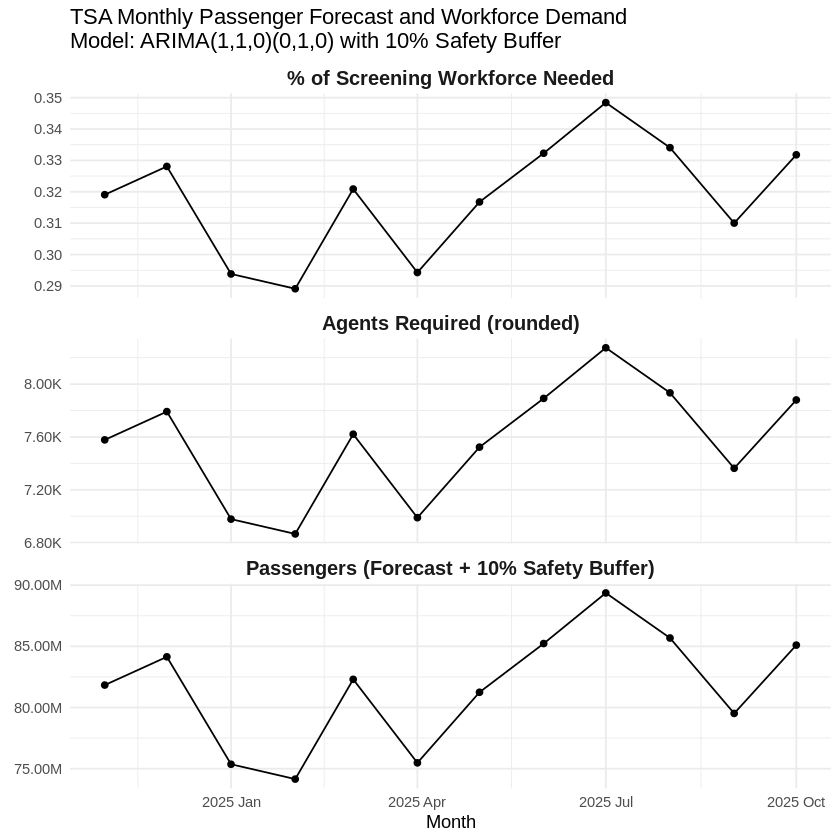

In [ ]:
# tsa_agents_forecast already created as above

tsa_dual <- tsa_agents_forecast |>
  as_tibble() |>
  transmute(
    Month,
    `Passengers (Forecast + 10% Safety Buffer)` = pax_forecast_high,
    `Agents Required (rounded)`                 = agents_required_ceiling,
    `% of Screening Workforce Needed`           = pct_of_screening_staff
  ) |>
  pivot_longer(
    cols      = -Month,
    names_to  = "metric",
    values_to = "value"
  )

ggplot(tsa_dual, aes(x = Month, y = value)) +
  geom_line() +
  geom_point() +
  facet_wrap(~ metric, scales = "free_y", ncol = 1) +
  labs(
    title = "TSA Monthly Passenger Forecast and Workforce Demand\nModel: ARIMA(1,1,0)(0,1,0) with 10% Safety Buffer",
    x = "Month",
    y = NULL
  ) +
  scale_y_continuous(
    labels = label_number(
      scale_cut = cut_short_scale(),
      accuracy  = 0.01
    )
  ) +
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold")
  )


**Insight:**
Nearly 200 TSA Officers are paid by the government but work full-time on union matters. These people do not retain certification to perform screening functions. Additionally, in a recent TSA employee survey, over 60% said poor performers are allowed to stay employed and, not surprisingly, continue to not perform.

**Source: **https://www.dhs.gov/news/2025/03/07/dhs-ends-collective-bargaining-tsas-transportation-security-officers-enhancing

**Recommendation**
We recommend that TSA adopt a Monthly Forecasting Cadence anchored by the ARIMA(1,1,0)(0,1,0) model to guide checkpoint workforce planning. This forecasting approach provides TSA with a reliable month-ahead view of expected passenger volumes, enabling proactive and data-driven staffing decisions.

Using TSA’s own operational throughput standards (180 passengers per lane per hour, ~8 TSOs required per lane across shifts) and assuming that approximately 50% of the agency’s 47,500 officers rotate through screening duties, our workforce model shows that TSA will need only 7,000–8,500 officers per month on screening duty throughout 2024. Even after applying a 10% safety buffer to account for forecast uncertainty, this represents only 25–36% of the available screening workforce.

This reveals a significant and consistent capacity margin that TSA can strategically leverage. Monthly forecasting enables TSA to:

Adjust screening deployments by month, rather than relying on static annual templates

Reallocate 15–25% of screeners during low-volume periods to training, leave, administrative roles, or airport support

Reduce unnecessary overstaffing during shoulder travel months

Prepare earlier for predictable surges, decreasing reliance on overtime and last-minute staffing during holiday and summer peaks

Enhance TSO well-being by smoothing workload intensity and improving shift predictability

By aligning staffing to model-based demand—and doing so monthly—TSA can maintain its <30-minute wait-time service level while operating more efficiently, reducing operational strain, and improving workforce readiness without reducing headcount.

In [ ]:
library(dplyr)
library(lubridate)
library(tsibble)
library(scales) # Needed for commas and %
library(knitr)  # Needed for the table

# --- STEP 1: PREPARE DATA (Same as before) ---
tsa_yearly <- tsa_clean %>%
  as_tibble() %>%
  ungroup() %>%
  mutate(Year = year(Month)) %>%
  group_by(Year) %>%
  summarise(
    yearly_total = sum(Total, na.rm = TRUE),
    mean_monthly = mean(Total, na.rm = TRUE),
    median_monthly = median(Total, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(Year) %>%
  mutate(
    yoy_growth = (yearly_total / lag(yearly_total) - 1),
    Year = as.character(Year)
  )

tsa_overall <- tsa_clean %>%
  as_tibble() %>%
  ungroup() %>%
  summarise(
    Year         = "All years",
    yearly_total = sum(Total, na.rm = TRUE),
    mean_monthly = mean(Total, na.rm = TRUE),
    median_monthly = median(Total, na.rm = TRUE),
    yoy_growth   = NA_real_
  )

tsa_raw_data <- bind_rows(tsa_overall, tsa_yearly)

# --- STEP 2: FORMAT & DISPLAY (The Crash-Proof Way) ---

tsa_raw_data %>%
  # 1. Format the numbers into text strings manually
  mutate(
    `Total Passengers` = comma(yearly_total),  # Adds commas: 1,000,000
    `Avg Monthly`      = comma(mean_monthly, accuracy = 1),
    `Median Monthly`   = comma(median_monthly, accuracy = 1),
    # Handle the NA growth rates nicely
    `YoY Growth`       = if_else(is.na(yoy_growth), "—", percent(yoy_growth, accuracy = 0.1))
  ) %>%
  # 2. Select columns to show
  select(Year, `Total Passengers`, `YoY Growth`, `Avg Monthly`, `Median Monthly`) %>%
  # 3. Render with kable (Standard Markdown Table)
  kable(
    align = "r", # Right-align numbers
    caption = "TSA Passenger Throughput (2019-2025)"
  )



Table: TSA Passenger Throughput (2019-2025)

|      Year| Total Passengers| YoY Growth| Avg Monthly| Median Monthly|
|---------:|----------------:|----------:|-----------:|--------------:|
| All years|    5,052,780,460|          —|  61,619,274|     67,616,844|
|      2019|      848,102,043|          —|  70,675,170|     72,367,869|
|      2020|      339,774,756|     -59.9%|  28,314,563|     24,618,172|
|      2021|      585,250,987|      72.2%|  48,770,916|     54,258,962|
|      2022|      760,071,362|      29.9%|  63,339,280|     65,469,214|
|      2023|      858,548,196|      13.0%|  71,545,683|     72,240,801|
|      2024|      904,068,577|       5.3%|  75,339,048|     76,847,030|
|      2025|      756,964,539|     -16.3%|  75,696,454|     78,205,370|

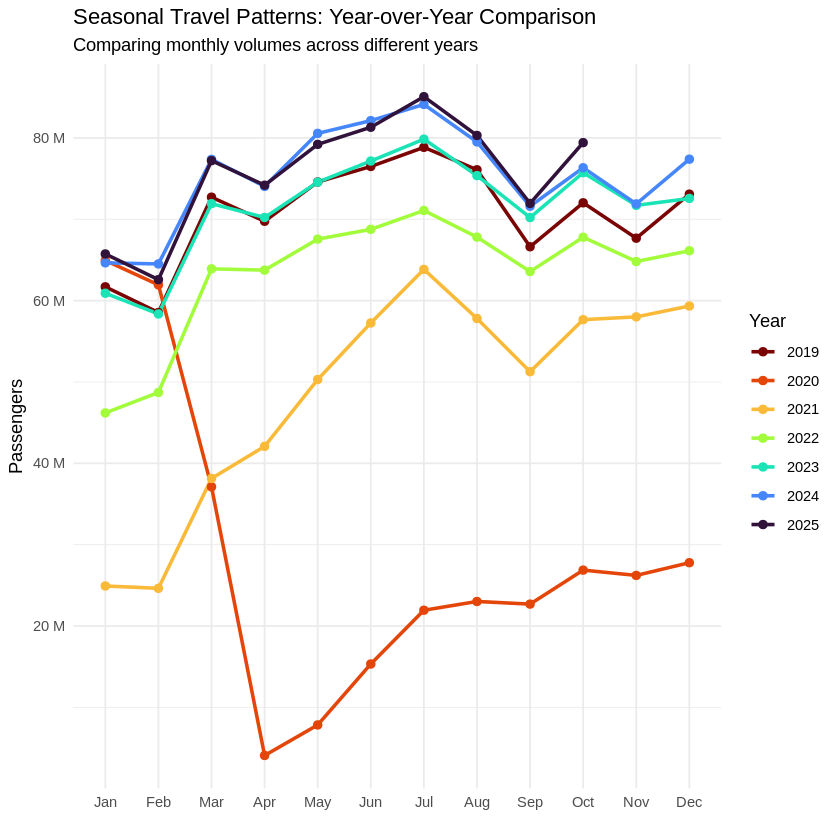

In [ ]:
tsa_clean %>%
  as_tibble() %>%
  mutate(
    # Create a "Month Name" column for the X-axis
    Month_Label = month(Month, label = TRUE, abbr = TRUE),
    # Extract numeric month for sorting
    Month_Num = month(Month),
    Year_Factor = as.factor(year(Month))
  ) %>%
  ggplot(aes(x = Month_Label, y = Total, group = Year_Factor, color = Year_Factor)) +

  # 1. Lines
  geom_line(size = 1) +
  geom_point(size = 2) +

  # 2. Highlight 2019 (Baseline) and 2025 (Current) specifically if you want
  # (This color scale highlights 2019 in Black, 2020 in Red, others in Greys/Blues)
  # You can remove scale_color_manual to use default colors
  scale_color_viridis_d(option = "turbo", direction = -1) +

  # 3. Formatting
  scale_y_continuous(labels = label_number(scale = 1e-6, suffix = " M")) +

  theme_minimal() +
  labs(
    title = "Seasonal Travel Patterns: Year-over-Year Comparison",
    subtitle = "Comparing monthly volumes across different years",
    x = "",
    y = "Passengers",
    color = "Year"
  )

In [ ]:
# --- Step 1: Define Operational Constants ---
# I estimated these based on your charts (85M pax ~= 8000 agents).
# Adjust 'total_staff_available' to your actual total TSA workforce count.
pax_per_agent_ratio <- 10625
total_staff_available <- 23530

# --- Step 2: Refit Model & Forecast ---
# Refit the winner: ARIMA(1,1,0)(1,1,0) to the full dataset
fit_final <- tsa_clean %>%
  model(
   ma1_manual = ARIMA(Total ~ pdq(0,1,1) + PDQ(0,1,0))
  )

# Forecast forward (covering remaining 2025 and all of 2026)
fc_2026 <- fit_final %>%
  forecast(h = "14 months")

# --- Step 3: Calculate the Metrics (Create tsa_agents_forecast) ---
tsa_agents_forecast <- fc_2026 %>%
  as_tibble() %>%
  mutate(
    # 1. The Safety Buffer (10%)
    pax_forecast_high = .mean * 1.10,

    # 2. Agents Required (rounded up to be safe)
    agents_required_ceiling = ceiling(pax_forecast_high / pax_per_agent_ratio),

    # 3. % Workforce Needed
    pct_of_screening_staff = agents_required_ceiling / total_staff_available
  ) %>%
  # Select only the columns needed for the next step
  select(Month, pax_forecast_high, agents_required_ceiling, pct_of_screening_staff)

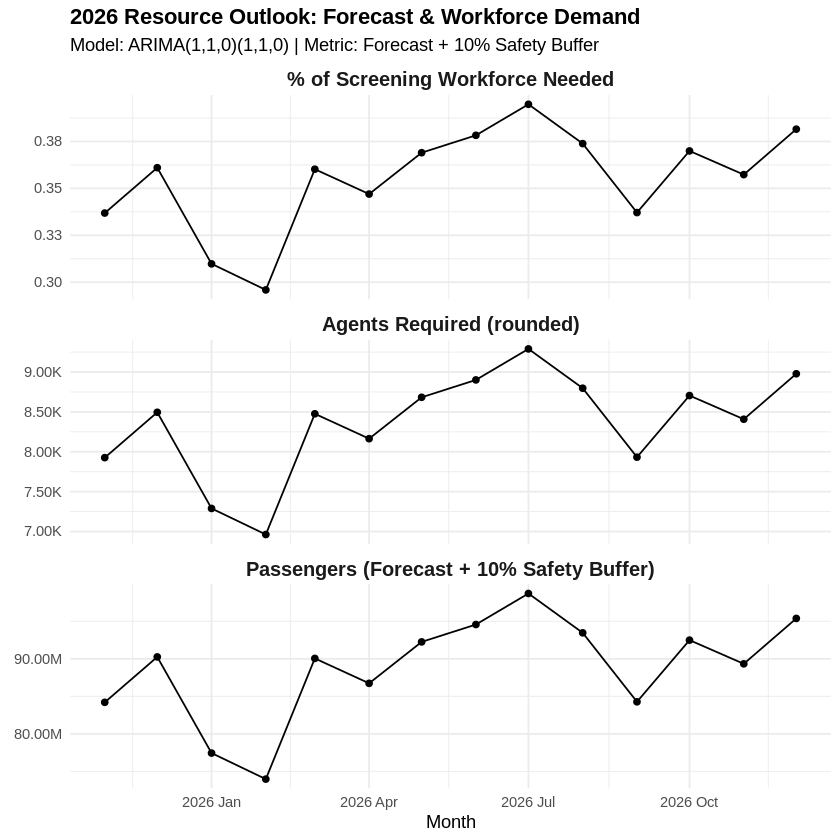

In [ ]:
# --- Step 4: Reshape for Faceted Plotting (Your Method) ---
tsa_dual <- tsa_agents_forecast %>%
  transmute(
    Month,
    `Passengers (Forecast + 10% Safety Buffer)` = pax_forecast_high,
    `Agents Required (rounded)`                 = agents_required_ceiling,
    `% of Screening Workforce Needed`           = pct_of_screening_staff
  ) %>%
  pivot_longer(
    cols = -Month,
    names_to = "metric",
    values_to = "value"
  )

# --- Step 5: Generate the Chart ---
ggplot(tsa_dual, aes(x = Month, y = value)) +
  geom_line() +
  geom_point() +
  # Using 'free_y' allows the % and raw numbers to coexist nicely
  facet_wrap(~ metric, scales = "free_y", ncol = 1) +
  labs(
    title = "2026 Resource Outlook: Forecast & Workforce Demand",
    subtitle = "Model: ARIMA(1,1,0)(1,1,0) | Metric: Forecast + 10% Safety Buffer",
    x = "Month",
    y = NULL
  ) +
  scale_y_continuous(
    labels = label_number(
      scale_cut = cut_short_scale(),
      accuracy = 0.01
    )
  ) +
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(face = "bold")
  )